# Day 19 – Pairs Trading with Cointegration (Engle–Granger) & Backtest

You’ll implement a **basic pairs trading strategy**:

1. Download two related stocks (default: **KO** & **PEP**).
2. Estimate the **hedge ratio** via OLS (Engle–Granger step 1).
3. Test the **spread** for stationarity (ADF test).
4. Build **z‑score** signals and **backtest** with simple transaction costs.
5. Evaluate **Sharpe**, **max drawdown**, and visualize the results.

> If downloads fail, the notebook falls back to a **synthetic cointegrated pair** so you can still run everything.


## Learning Objectives
- Practice the **Engle–Granger cointegration** workflow for pairs.
- Learn how to derive a **mean‑reverting spread** and build **z‑score** signals.
- Implement a simple **backtest** with **transaction costs** and compute key metrics.

## Key Concepts
- **Cointegration:** while individual prices are nonstationary (random walk), a particular **linear combination** can be stationary.
- **Hedge ratio (β):** from regressing \(Y_t\) on \(X_t\), so the spread \(\varepsilon_t = Y_t - \alpha - \beta X_t\) is hopefully stationary.
- **Z‑score:** standardized spread allowing threshold rules: enter at |z| high, exit near 0.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller

# Utility: performance metrics
def sharpe_ratio(returns, periods_per_year=252):
    mu = returns.mean() * periods_per_year
    sig = returns.std(ddof=1) * np.sqrt(periods_per_year)
    return np.nan if sig == 0 else mu / sig

def max_drawdown(cum_curve):
    roll_max = cum_curve.cummax()
    dd = cum_curve / roll_max - 1.0
    return dd.min()

print("Imports ready.")

Imports ready.


In [2]:
# --- User parameters ---
tickers = ("KO", "PEP")        # Coca-Cola vs PepsiCo (highly related competitors)
start_date = "2015-01-01"
end_date   = "2025-01-01"

roll_z = 60                    # rolling window for z-score (days)
entry_z = 2.0                  # enter when |z| >= entry_z
exit_z  = 0.5                  # exit when |z| <= exit_z

cost_per_change = 0.001        # ~10 bps per notional change in spread (both legs combined)
capital = 100_000              # notional for equity curve scaling

print(f"Pair={tickers}, window={roll_z}, entry={entry_z}, exit={exit_z}")

Pair=('KO', 'PEP'), window=60, entry=2.0, exit=0.5


In [3]:
# Try yfinance; fallback to synthetic cointegrated series if it fails
have_real = False
px = None

try:
    import yfinance as yf
    data = yf.download(list(tickers), start=start_date, end=end_date, auto_adjust=True, progress=False)['Close']
    if isinstance(data, pd.Series):
        data = data.to_frame()
    data = data.dropna()
    if data.shape[1] >= 2 and len(data) > roll_z + 30:
        px = data.iloc[:, :2].copy()
        px.columns = [str(c) for c in px.columns]
        have_real = True
        print(f"Downloaded {px.shape[0]} rows for {list(px.columns)}")
    else:
        print("Not enough data after cleaning; will use synthetic.")
except Exception as e:
    print("Download failed:", repr(e))

if not have_real:
    np.random.seed(123)
    n = 1500
    # build a random walk X in log space
    x = np.cumsum(np.random.normal(0, 0.01, size=n))
    # cointegrated Y: y = alpha + beta * x + stationary noise
    alpha_true, beta_true = 0.2, 1.05
    eps = np.random.normal(0, 0.02, size=n)
    y = alpha_true + beta_true * x + eps
    # map to prices (exp of logs)
    Xp = np.exp(x) * 50.0
    Yp = np.exp(y) * 20.0
    idx = pd.bdate_range("2018-01-01", periods=n)
    px = pd.DataFrame({tickers[0]: Yp, tickers[1]: Xp}, index=idx)
    print(f"Using synthetic pair with {n} points.")

Downloaded 2516 rows for ['KO', 'PEP']


In [4]:
# Choose Y ~ alpha + beta X
y_name, x_name = px.columns[0], px.columns[1]
Y = np.log(px[y_name])
X = np.log(px[x_name])

X1 = add_constant(X)
model = OLS(Y, X1).fit()
alpha_hat = model.params['const']
beta_hat  = model.params[X.name]

spread = Y - (alpha_hat + beta_hat * X)

print(model.summary())
print(f"Estimated hedge ratio beta ≈ {beta_hat:.4f}")

                            OLS Regression Results                            
Dep. Variable:                     KO   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                 5.475e+04
Date:                Mon, 25 Aug 2025   Prob (F-statistic):               0.00
Time:                        14:08:23   Log-Likelihood:                 3898.1
No. Observations:                2516   AIC:                            -7792.
Df Residuals:                    2514   BIC:                            -7780.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0448      0.016     -2.754      0.0

In [5]:
# Engle–Granger step 2: ADF test on spread
adf_stat, pval, lags, nobs, crit, _ = adfuller(spread.dropna(), maxlag=10, autolag='AIC')
print(f"ADF stat={adf_stat:.3f}, p-value={pval:.4f}, usedlag={lags}, nobs={nobs}")
print("Critical values:", crit)

# Note: p-value < 0.05 suggests stationarity (good for mean-reverting spread).


ADF stat=-2.992, p-value=0.0357, usedlag=9, nobs=2506
Critical values: {'1%': np.float64(-3.432962135264372), '5%': np.float64(-2.862694028699462), '10%': np.float64(-2.567384333962417)}


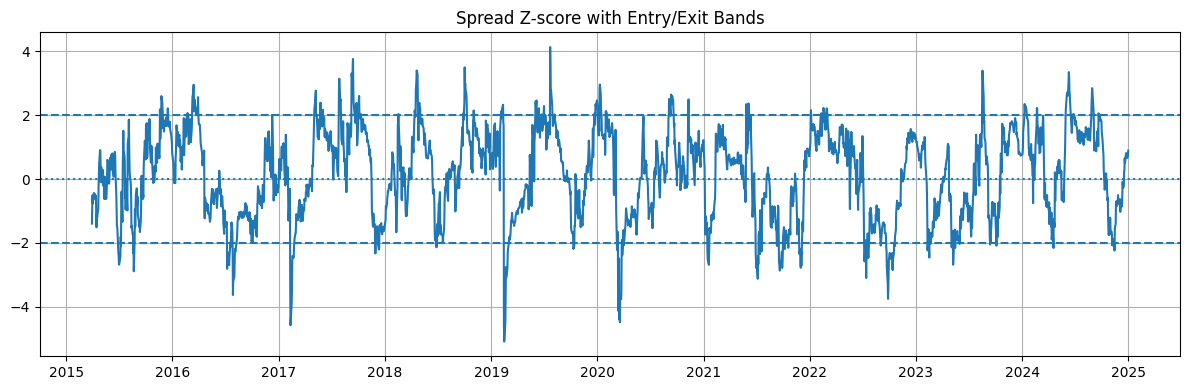

In [6]:
# Rolling z-score on spread
roll_mean = spread.rolling(roll_z).mean()
roll_std  = spread.rolling(roll_z).std(ddof=1)
z = (spread - roll_mean) / roll_std

# Signals: +1 = long spread (long Y / short beta*X); -1 = short spread; 0 = flat
long_sig  = (z < -entry_z).astype(int)
short_sig = (z > entry_z).astype(int) * -1

# Exit when |z| <= exit_z -> go flat
flat = (z.abs() <= exit_z).astype(int)

# Position logic: prefer most recent non-flat unless exit condition
position = pd.Series(0, index=z.index, dtype=float)
current = 0
for t in range(len(z)):
    if long_sig.iat[t] == 1:
        current = 1
    elif short_sig.iat[t] == -1:
        current = -1
    elif flat.iat[t] == 1:
        current = 0
    position.iat[t] = current

position = position.where(~position.isna(), 0.0)

# Plot z with bands & positions
plt.figure(figsize=(12,4))
plt.plot(z.index, z, label='z-score (spread)')
plt.axhline(entry_z, linestyle='--')
plt.axhline(-entry_z, linestyle='--')
plt.axhline(0, linestyle=':')
plt.title('Spread Z-score with Entry/Exit Bands')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Backtest: one-unit spread => weights: +1 on Y, -beta on X (dollar-neutral in log space proxy)
wY = 1.0
wX = -beta_hat

# Daily returns of prices (log returns approximate)
retY = Y.diff().fillna(0)        # log-return
retX = X.diff().fillna(0)

# Spread return per unit
spread_ret = wY*retY + wX*retX

# Strategy return = previous day's position * today's spread return
strat_ret_gross = position.shift(1).fillna(0) * spread_ret

# Transaction costs when position changes
pos_change = position.diff().abs().fillna(0)  # 1 on entry/exit/flip
# Assume cost proportional to |weights| on both legs per change
notional_per_unit = abs(wY) + abs(wX)
tc = cost_per_change * notional_per_unit * pos_change

strat_ret_net = strat_ret_gross - tc

# Equity curve
equity = (1.0 + strat_ret_net).cumprod() * (capital / (1.0 + strat_ret_net).iloc[0])
equity = equity.fillna(method='ffill')

# Metrics
sr = sharpe_ratio(strat_ret_net)
mdd = max_drawdown(equity / equity.iloc[0])

print(f"Sharpe (ann.) ≈ {sr:.2f}") 
print(f"Max Drawdown ≈ {mdd:.2%}")

Sharpe (ann.) ≈ -0.20
Max Drawdown ≈ -28.51%


C:\Users\vedik\AppData\Local\Temp\ipykernel_12160\2310345020.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  equity = equity.fillna(method='ffill')


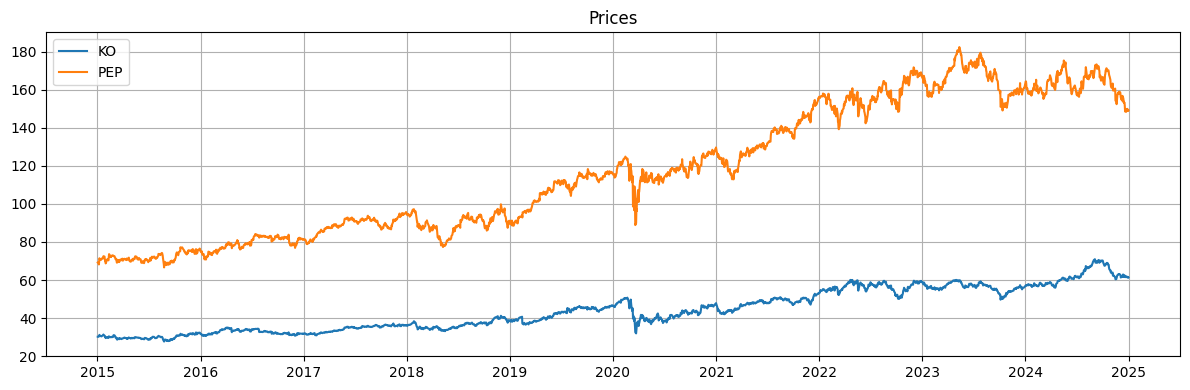

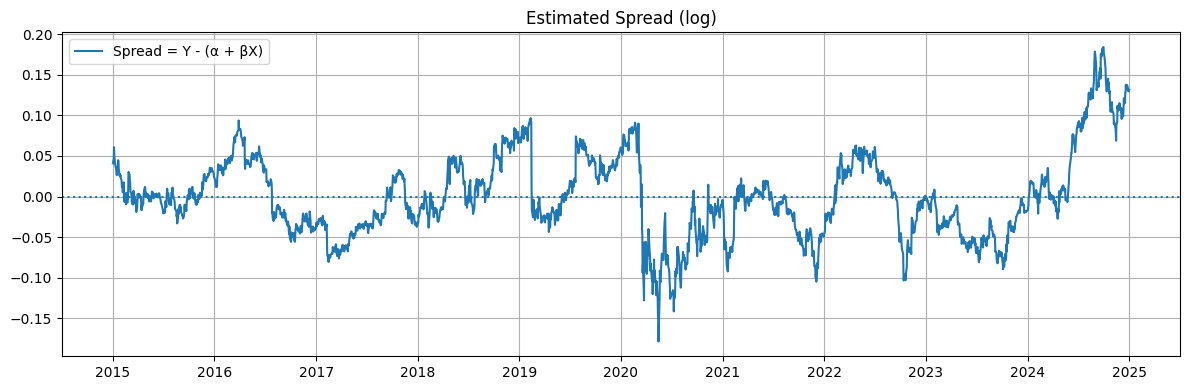

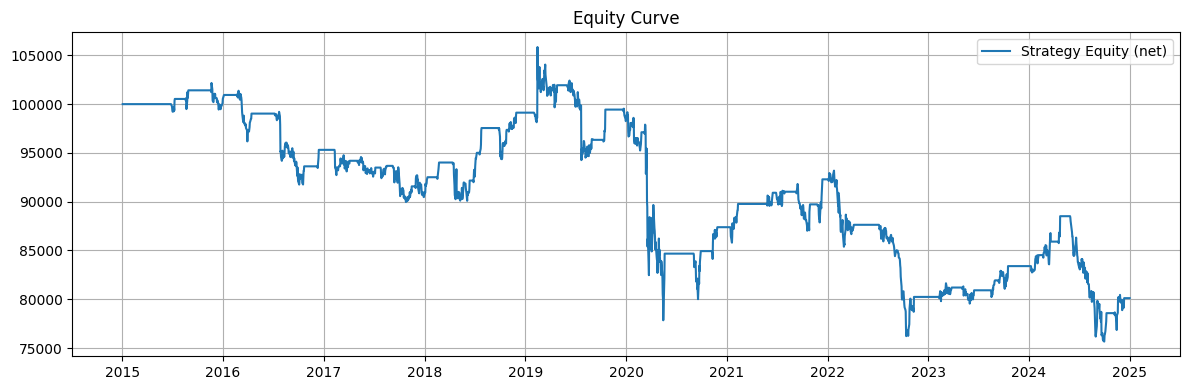

In [8]:
# Prices
plt.figure(figsize=(12,4))
plt.plot(px.index, px[y_name], label=y_name)
plt.plot(px.index, px[x_name], label=x_name)
plt.title('Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Spread
plt.figure(figsize=(12,4))
plt.plot(spread.index, spread, label='Spread = Y - (α + βX)')
plt.axhline(0, linestyle=':')
plt.title('Estimated Spread (log)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Equity curve
plt.figure(figsize=(12,4))
plt.plot(equity.index, equity, label='Strategy Equity (net)')
plt.title('Equity Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary & Next Steps

- We estimated a **hedge ratio** and verified that the **spread** has some stationarity (ADF).
- A simple **z‑score strategy** can profit from mean reversion—but is sensitive to **window**, **thresholds**, **costs**, and **pair choice**.
- In practice, you’ll want **robust entry/exit**, **stop‑loss**, position sizing, and **universe selection** based on strong cointegration evidence.

**Try:**
1. Swap pairs (e.g., `('XOM','CVX')`, `('MSFT','AAPL')`) and re‑run.
2. Grid‑search over `roll_z`, `entry_z`, `exit_z` to find robust params (walk‑forward split!).
3. Use **Johansen test** for multi-asset cointegration and build **stat‑arb baskets**.
4. Add **Kelly sizing** or volatility scaling for risk control.
